<a href="https://colab.research.google.com/github/jinyang628/imageMultiClassification/blob/main/ImageMulticlassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
# Make sure whatever dataset you use has the labels as the subfolder names
!pip install kaggle
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [120]:
# To get dataset from kaggle, upload the kaggle.json file
!chmod 600 /content/kaggle.json

# Got the dataset from https://www.kaggle.com/datasets/jehanbhathena/weather-dataset
# The last 2 parameters username/dataset-name is the download path
!kaggle datasets download -d jehanbhathena/weather-dataset

weather-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [121]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import pathlib
import zipfile
import os
import matplotlib.pyplot as plt

In [122]:
from sklearn.preprocessing import LabelEncoder# The downloaded zipfile is named weather-dataset.zip
with zipfile.ZipFile('/content/weather-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [123]:
# The unzipped folder is named dataset
data_dir = pathlib.Path("/content/dataset")

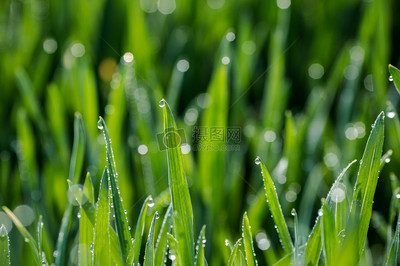

In [124]:
# There is a label/subfolder named dew. Test whether the images have been imported properly
dew = list(data_dir.glob('dew/*'))
PIL.Image.open(str(dew[0]))

In [125]:
# Each image may be of different height and width so we need to standardise everything
img_height,img_width=180,180
batch_size=32

# Common seed value ensures training and validation sets are distinct
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

# Names of labels/subfolders
class_names = train_ds.class_names
labels_count = len(class_names)
print(class_names)

# Calculate the number of samples in the training dataset
train_ds_size = sum(1 for _ in train_ds)

test_ds_size = train_ds_size // 10  # 10% of the training dataset

# Split the training data into training and testing sets
test_ds = train_ds.take(test_ds_size)
train_ds = train_ds.skip(test_ds_size)

Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Found 6862 files belonging to 11 classes.
Using 1372 files for validation.
['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


In [126]:
resnet_model = Sequential()

"""
include_top=False because we are using our own input and output layers for finetuning
The original model might be trained with images of different dimensions

pooling='avg' takes the spatial dimensions (height and width) of the output tensor from
the last convolutional layer and reduces it to 1x1 by taking the average of all
the values. Average pooling is commonly used for transfer learning and fine-tuning
because it provides a global average representation of the entire image's
features for classification tasks

weights='imagenet' simply means we are using the pre-trained weights from the
ImageNet dataset
"""
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(img_height,img_width,3),
                   pooling='avg',classes=labels_count,
                   weights='imagenet')
"""
We dont want to retrain the weights in the existing model and just train the input
and output layer
"""
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

"""
The Flatten() layer takes the output from the last layer of the ResNet-50
(which is a 2D tensor with spatial dimensions reduced to 1x1 by global average
pooling) and flattens it into a one-dimensional tensor. The flattening operation
is necessary because the Dense layers that follow require one-dimensional input.
"""
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(labels_count, activation='softmax'))

In [127]:
resnet_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_27 (ModuleWr  (None, 2048)             0         
 apper)                                                          
                                                                 
 module_wrapper_28 (ModuleWr  (None, 512)              1049088   
 apper)                                                          
                                                                 
 module_wrapper_29 (ModuleWr  (None, 11)               5643      
 apper)                                                          
                                                                 
Total params: 24,642,443
Trainable params: 1,054,731
Non-trainable params: 23,587,712
__________________________________

In [128]:
resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

In [129]:
history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2
)

Epoch 1/2
155/155 [==============================] - 37s 156ms/step - loss: 0.6810 - accuracy: 0.7831 - val_loss: 0.5754 - val_accuracy: 0.7996
Epoch 2/2
155/155 [==============================] - 23s 134ms/step - loss: 0.3141 - accuracy: 0.8880 - val_loss: 0.5043 - val_accuracy: 0.8411


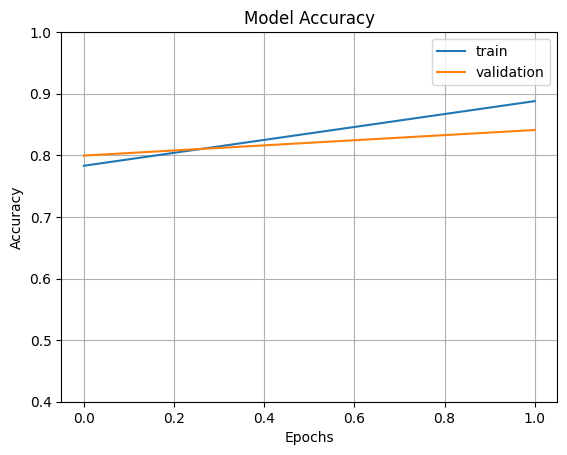

In [130]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

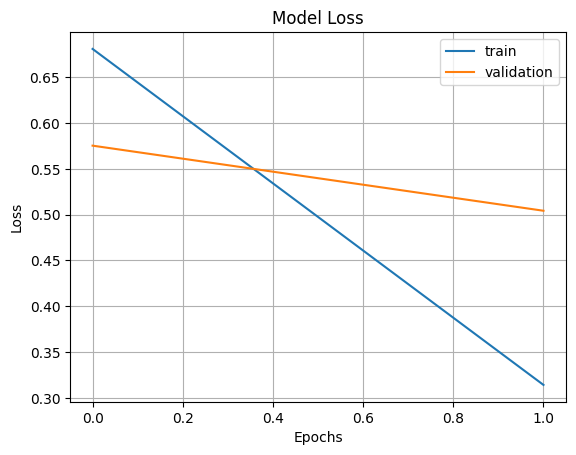

In [131]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

1/1 [==============================] - 1s 1s/step


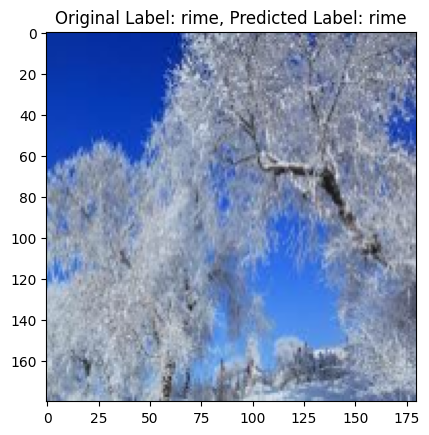

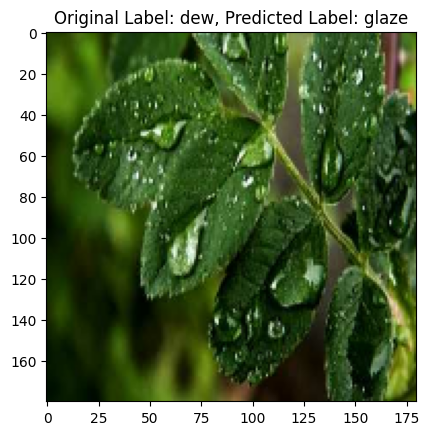

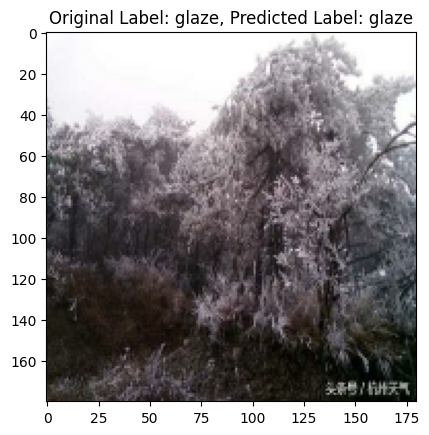

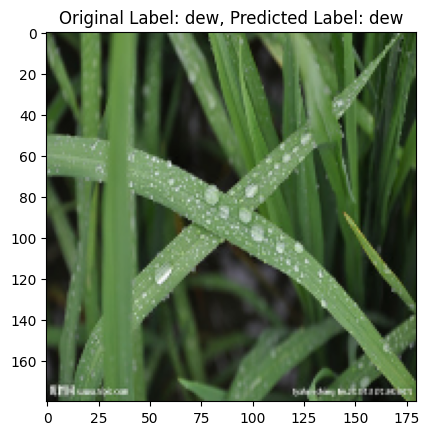

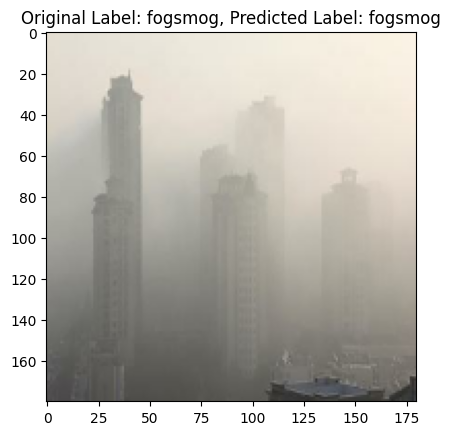

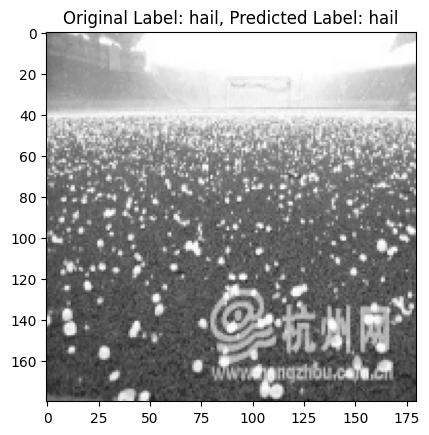

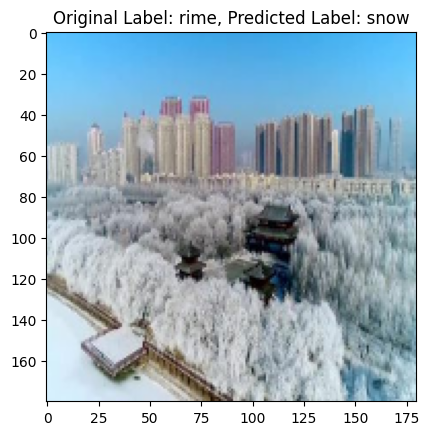

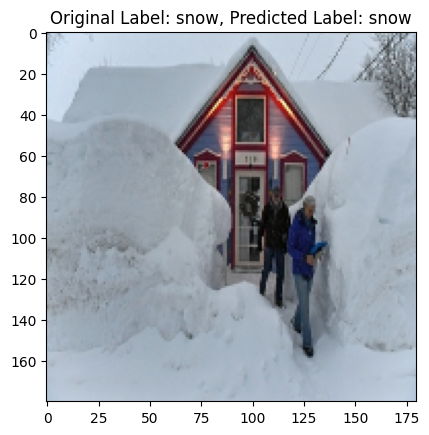

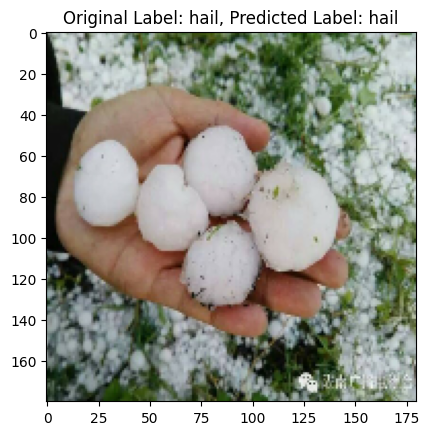

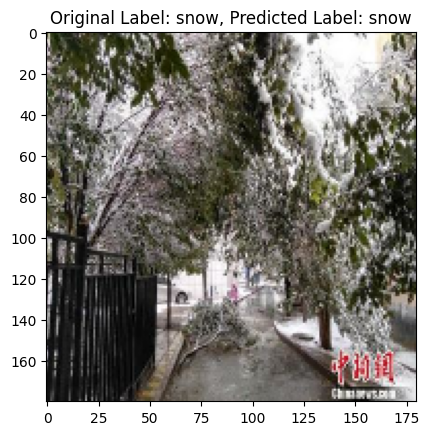

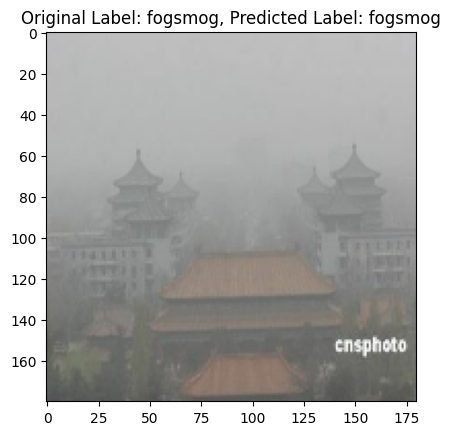

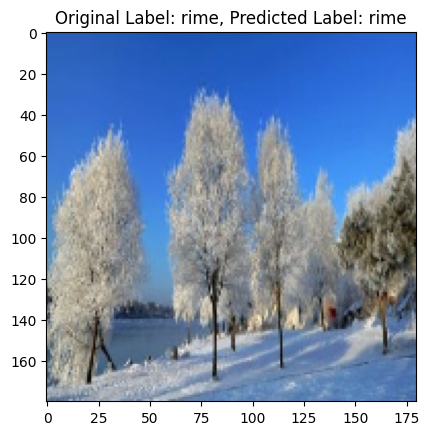

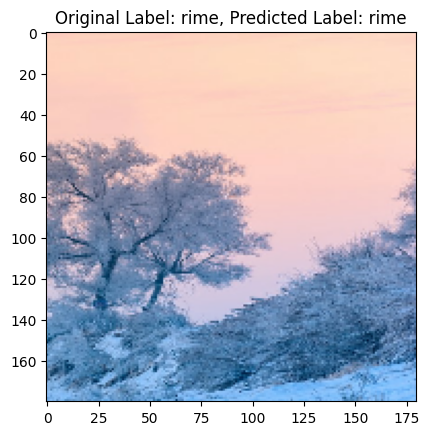

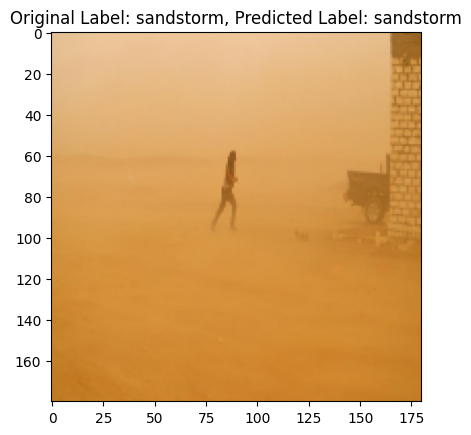

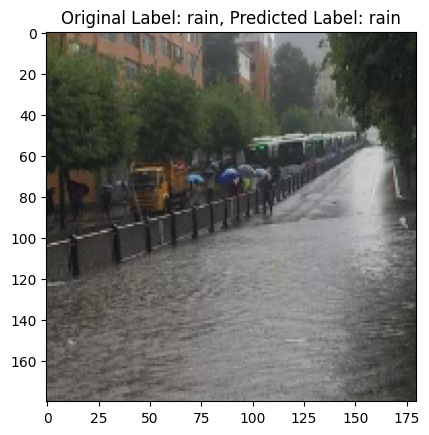

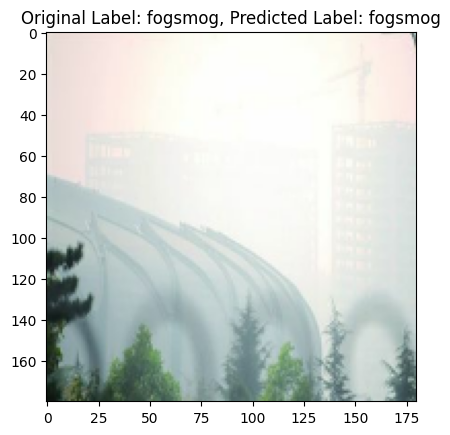

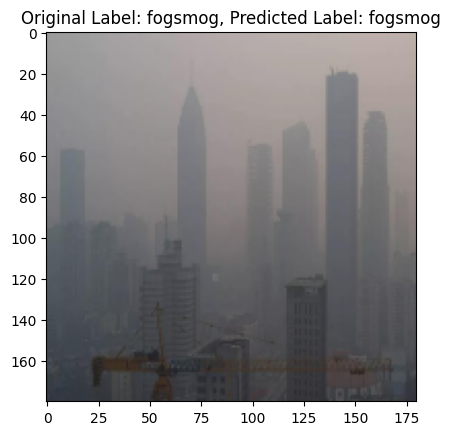

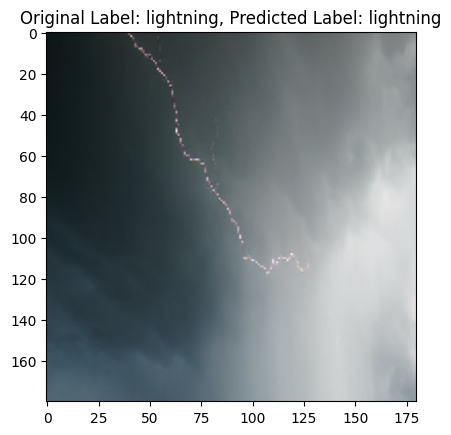

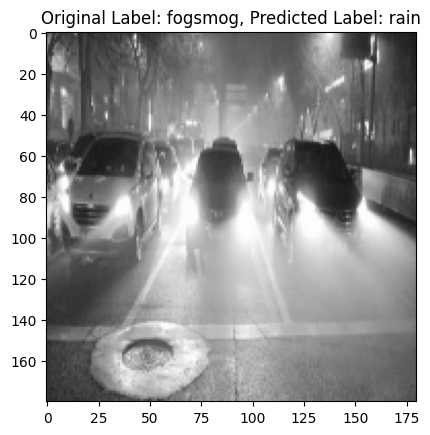

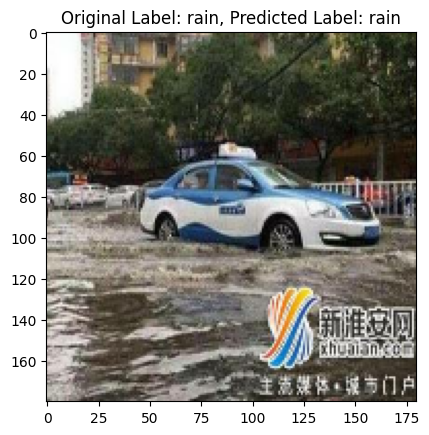

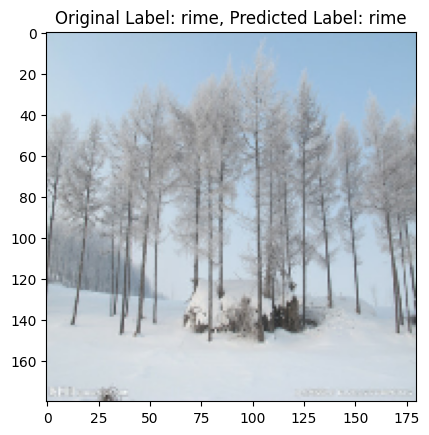

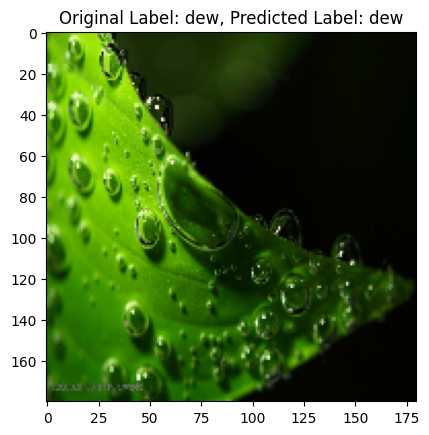

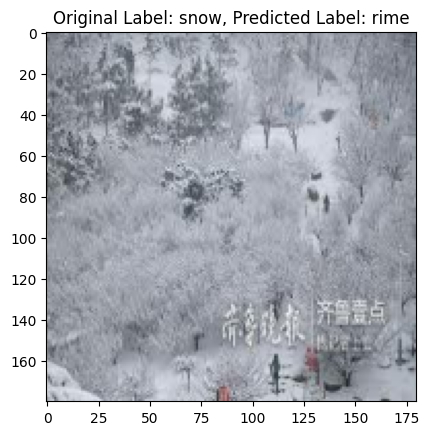

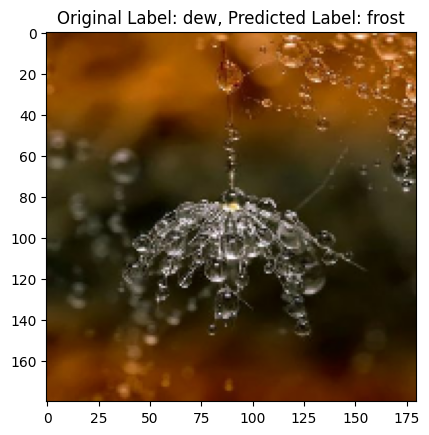

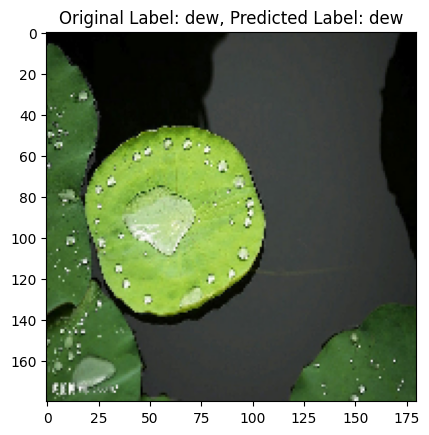

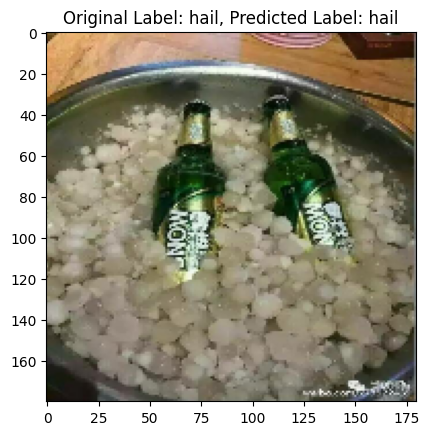

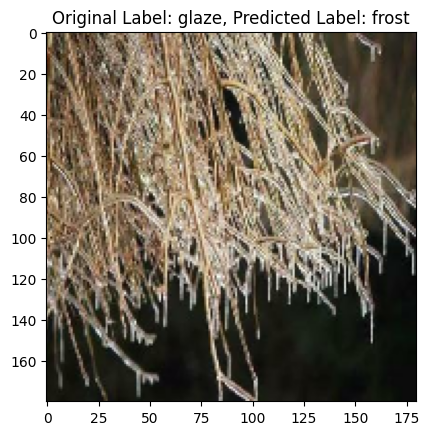

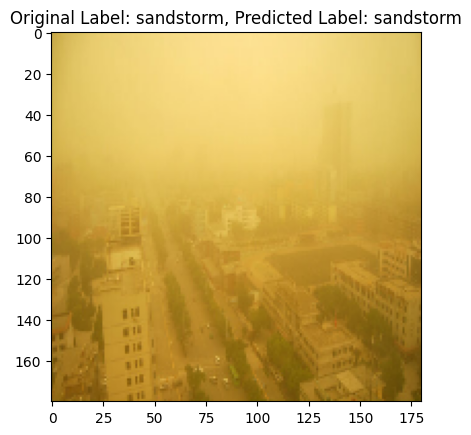

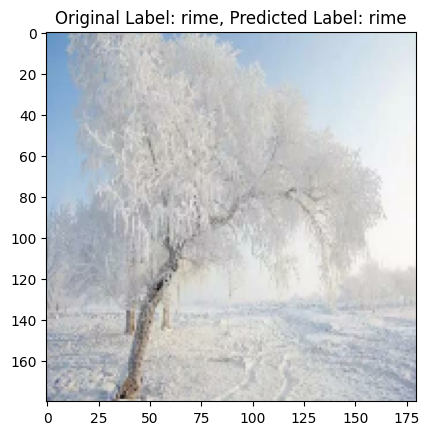

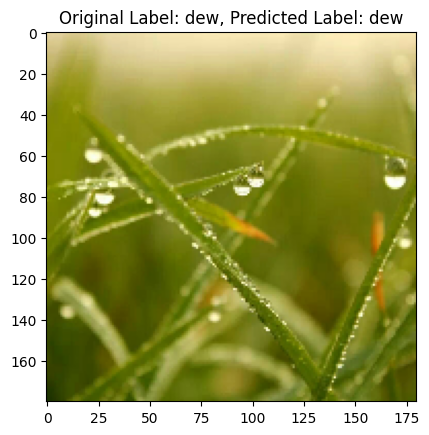

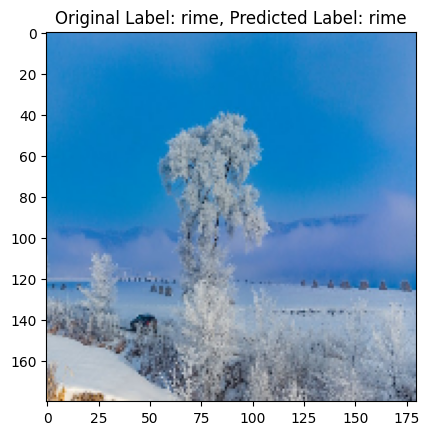

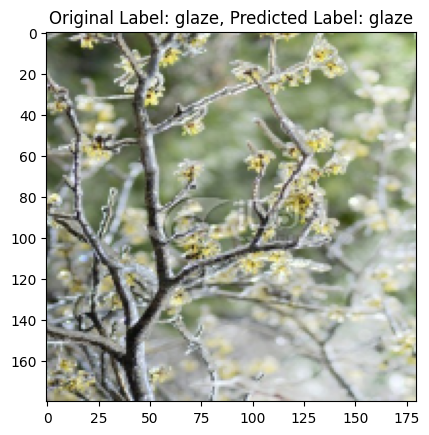

In [132]:

# Get the first batch of the test dataset
first_batch_images, first_batch_labels = next(iter(test_ds))

# Perform predictions on the first batch
predictions = resnet_model.predict(first_batch_images)

# Convert the one-hot encoded predictions to integer labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the original labels (names of the subfolders) for each image in the first batch
original_labels = [class_names[label] for label in first_batch_labels]

# Plot the first image and print the original and predicted labels
for i in range(len(first_batch_images)):
    plt.imshow(first_batch_images[i].numpy().astype("uint8"))
    plt.title(f"Original Label: {original_labels[i]}, Predicted Label: {class_names[predicted_labels[i]]}")
    plt.show()
